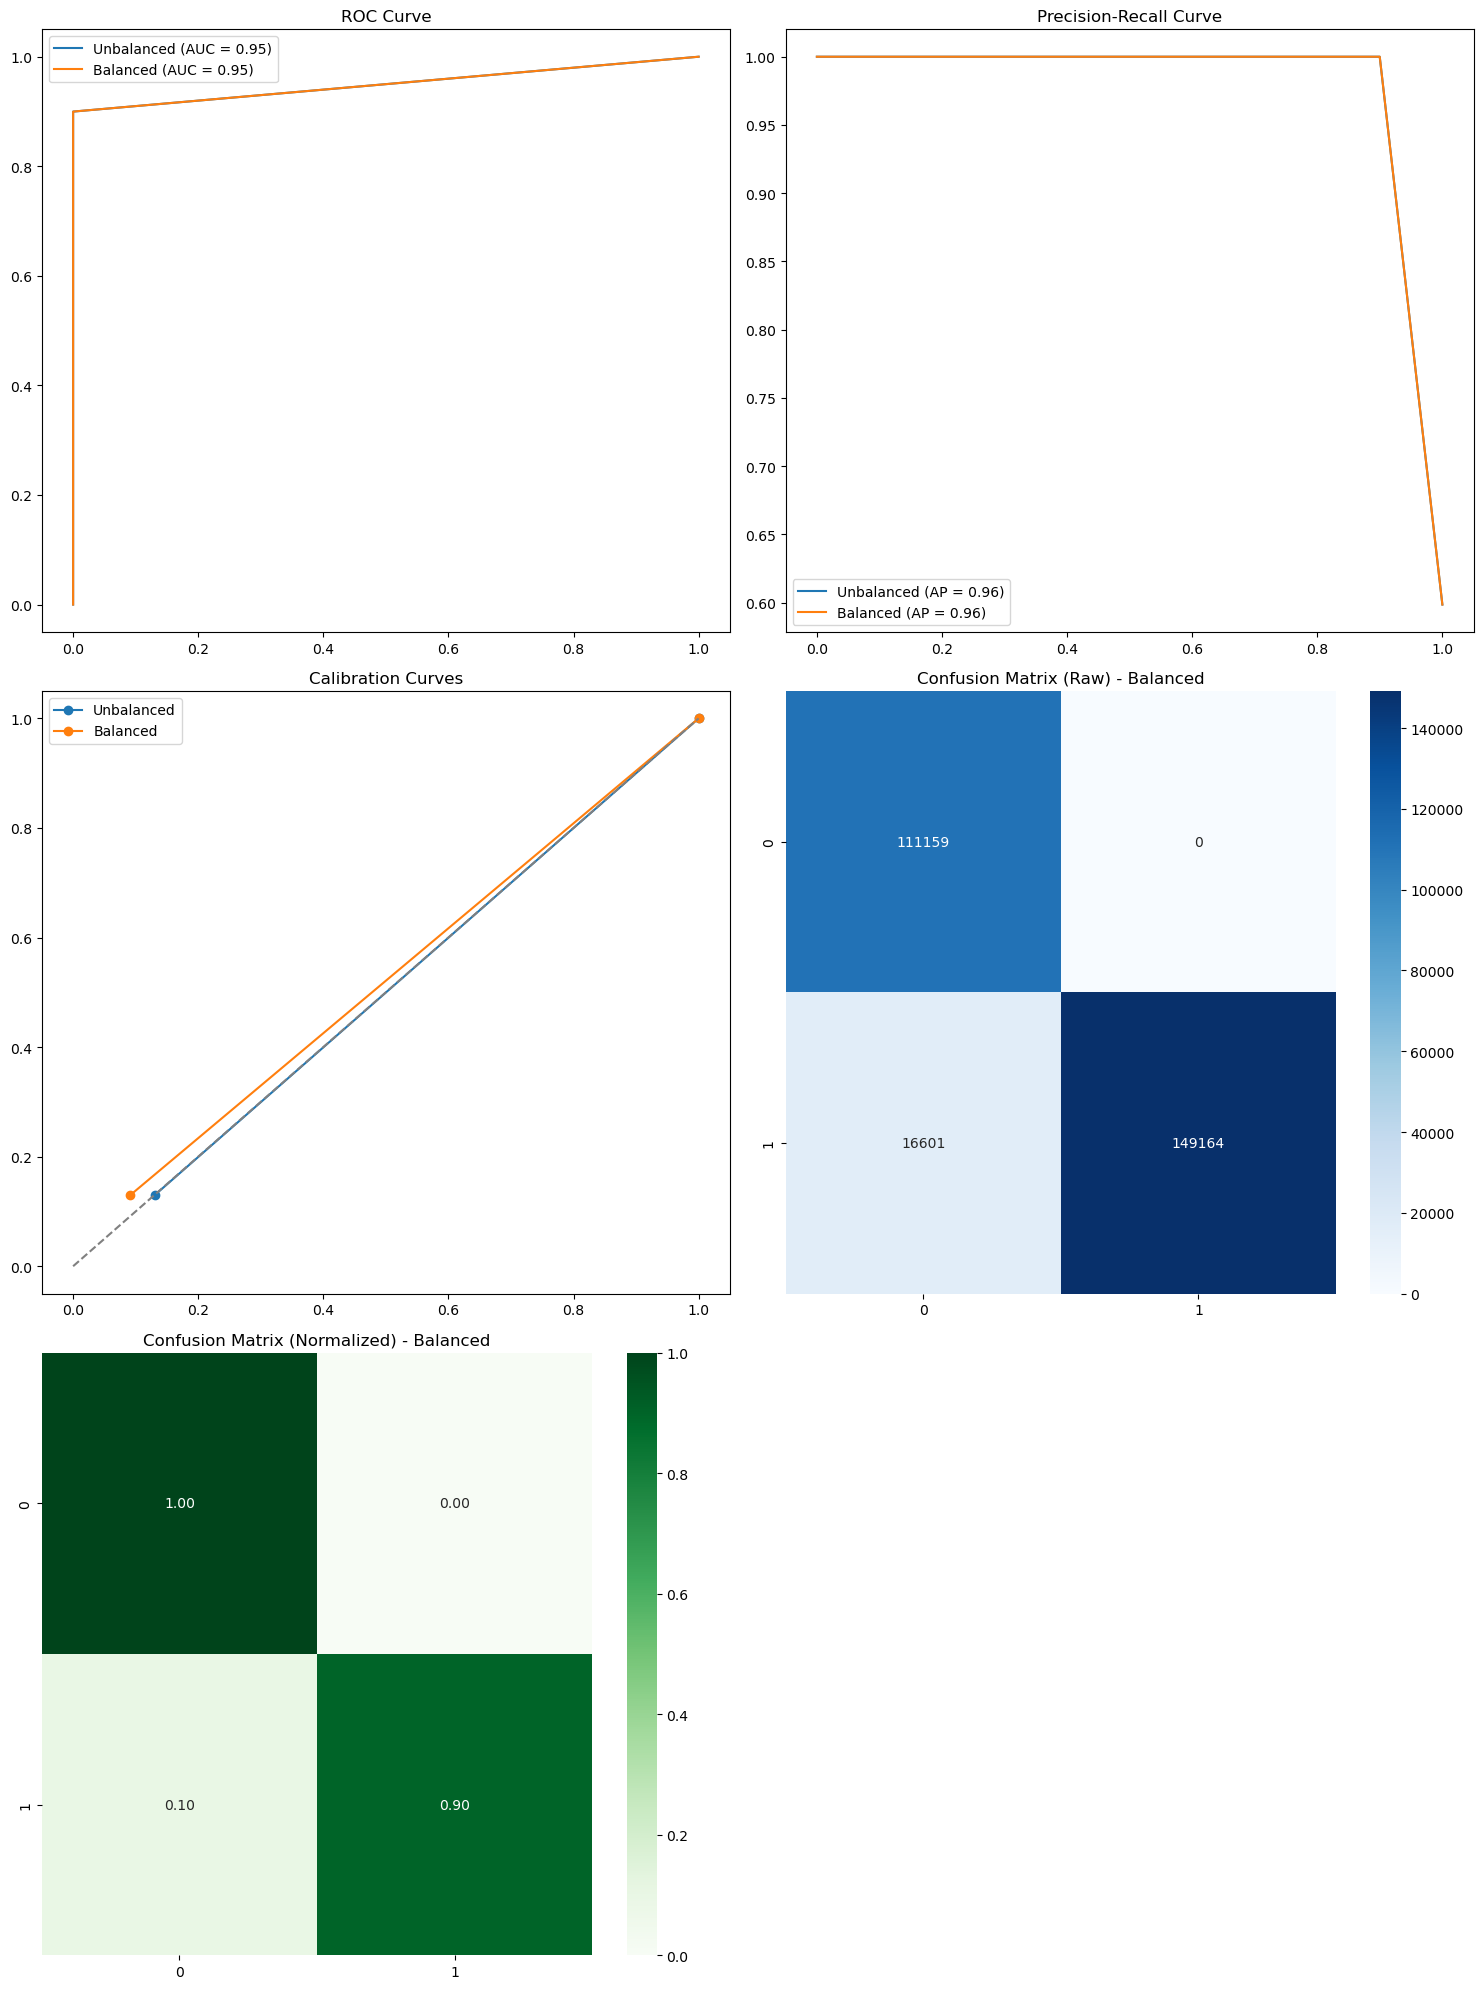


--- Summary Comparison Table ---
     Model  Accuracy  Precision   Recall  F1-Score      MCC
Unbalanced  0.940052        1.0 0.899852  0.947287 0.884831
  Balanced  0.940052        1.0 0.899852  0.947287 0.884831

--- Detailed Classification Reports ---

Report for Unbalanced:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    111159
           1       1.00      0.90      0.95    165765

    accuracy                           0.94    276924
   macro avg       0.94      0.95      0.94    276924
weighted avg       0.95      0.94      0.94    276924


Report for Balanced:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    111159
           1       1.00      0.90      0.95    165765

    accuracy                           0.94    276924
   macro avg       0.94      0.95      0.94    276924
weighted avg       0.95      0.94      0.94    276924



In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, classification_report
)
from sklearn.calibration import calibration_curve


df = pd.read_parquet('instacart_final_fixed.parquet')
X = df.drop(columns=['order_id', 'user_id', 'product_id', 'reordered', 'add_to_cart_order'], errors='ignore')
y = df['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


models = {
    "Unbalanced": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Balanced": DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42)
}


results = []


fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

for i, (name, clf) in enumerate(models.items()):
   
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    results.append([name, acc, prec, rec, f1, mcc])
    
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    axes[1].plot(recall, precision, label=f'{name} (AP = {ap:.2f})')
    
   
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    axes[2].plot(prob_pred, prob_true, marker='o', label=f'{name}')
    
   
    if name == "Balanced":
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[3], cmap='Blues')
        axes[3].set_title(f'Confusion Matrix (Raw) - {name}')
        
        cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
        sns.heatmap(cm_norm, annot=True, fmt='.2f', ax=axes[4], cmap='Greens')
        axes[4].set_title(f'Confusion Matrix (Normalized) - {name}')


axes[0].set_title('ROC Curve')
axes[0].legend()
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray') 
axes[2].set_title('Calibration Curves')
axes[2].legend()


fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC'])
print("\n--- Summary Comparison Table ---")
print(df_results.to_string(index=False))

print("\n--- Detailed Classification Reports ---")
for name, clf in models.items():
    print(f"\nReport for {name}:")
    print(classification_report(y_test, clf.predict(X_test)))

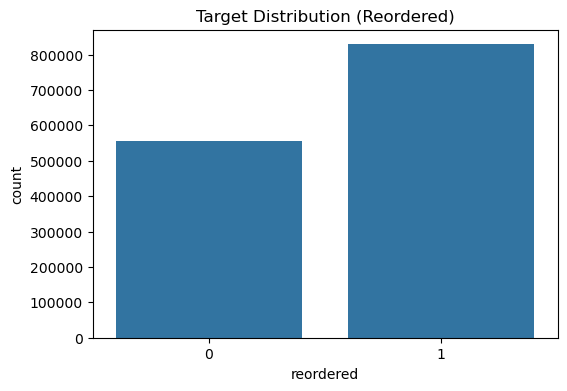

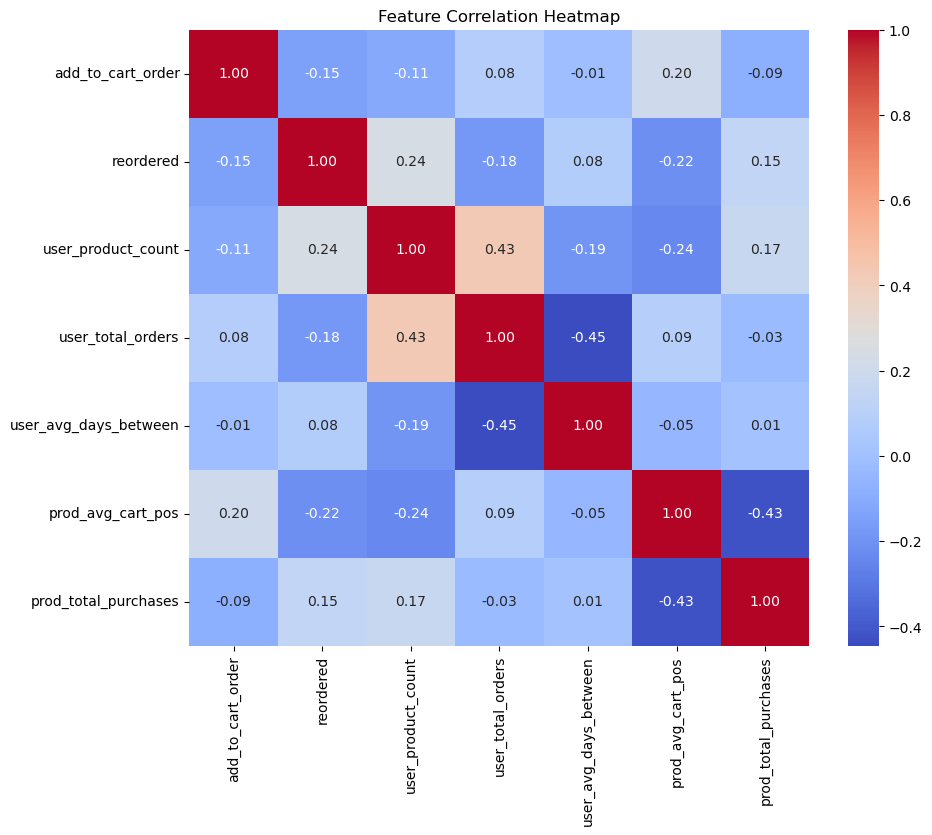

In [91]:

plt.figure(figsize=(6, 4))
sns.countplot(x='reordered', data=df)
plt.title('Target Distribution (Reordered)')
plt.show()


plt.figure(figsize=(10, 8))
corr = df.drop(columns=['order_id', 'user_id', 'product_id'], errors='ignore').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

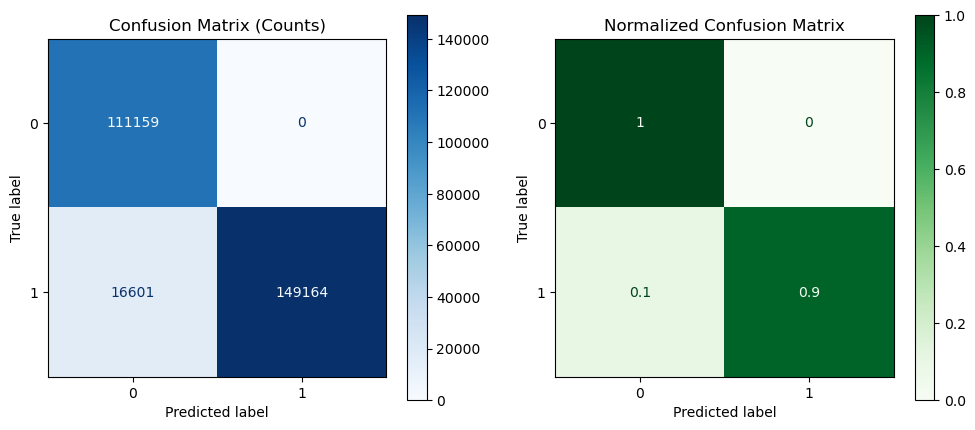

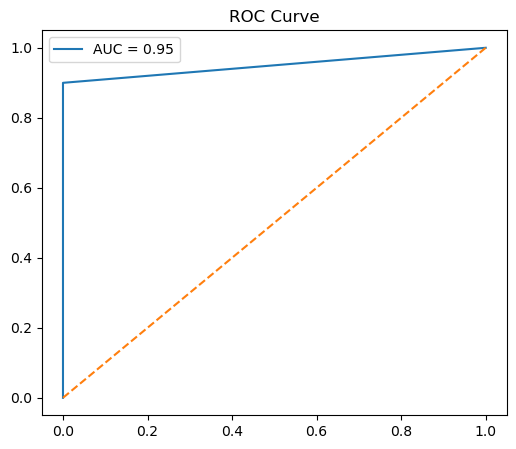

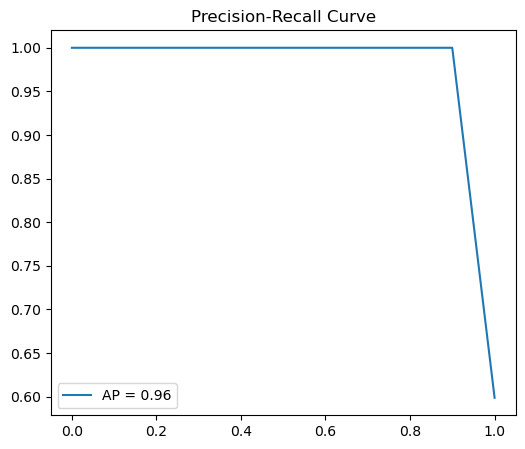

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(dt_balanced, X_test, y_test, cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Counts)')

ConfusionMatrixDisplay.from_estimator(dt_balanced, X_test, y_test, cmap='Greens', normalize='true', ax=ax[1])
ax[1].set_title('Normalized Confusion Matrix')
plt.show()


y_proba = dt_balanced.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], '--')
plt.title('ROC Curve')
plt.legend()
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {average_precision_score(y_test, y_proba):.2f}')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

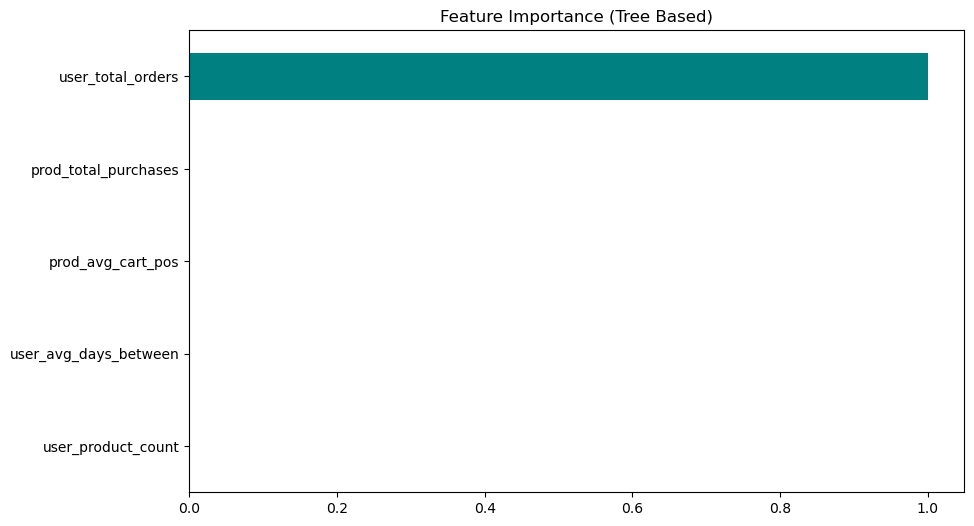

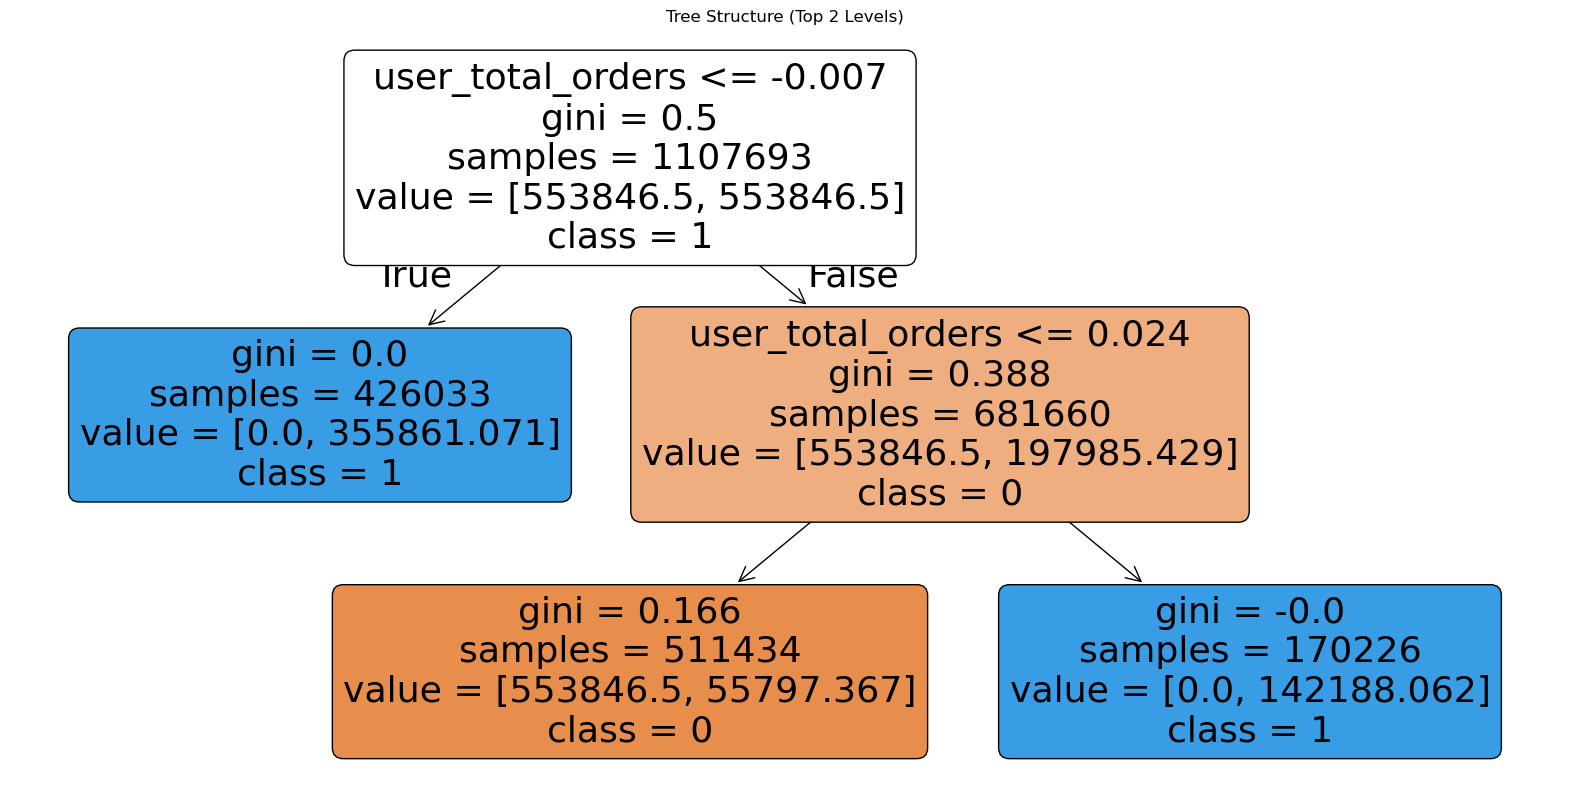

In [93]:
from sklearn.tree import plot_tree



plt.figure(figsize=(10, 6))
feat_importances = pd.Series(dt_balanced.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importance (Tree Based)')
plt.show()


plt.figure(figsize=(20, 10))
plot_tree(dt_balanced, max_depth=2, feature_names=X.columns, class_names=['0', '1'], filled=True, rounded=True)
plt.title('Tree Structure (Top 2 Levels)')
plt.show()

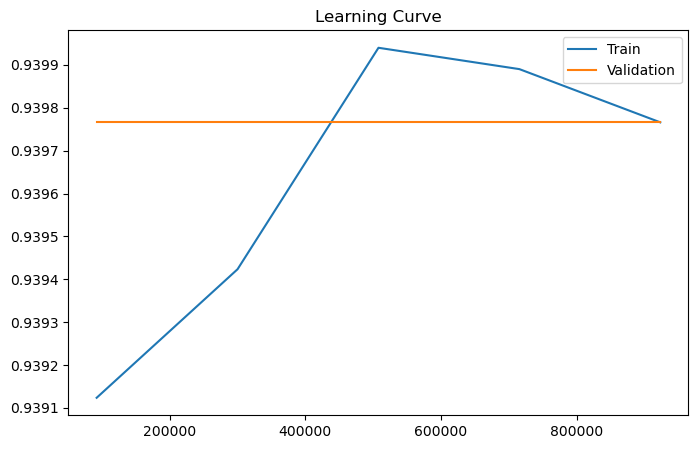

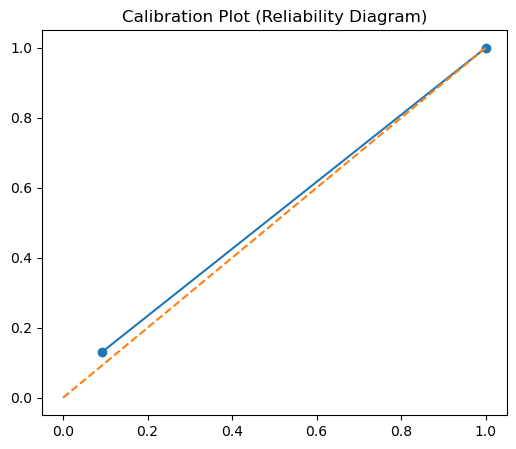

In [94]:
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve


train_sizes, train_scores, test_scores = learning_curve(dt_balanced, X, y, cv=3)
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation')
plt.title('Learning Curve')
plt.legend()
plt.show()


prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], '--')
plt.title('Calibration Plot (Reliability Diagram)')
plt.show()

In [95]:
import plotly.graph_objects as go


depths = np.arange(1, 11)
acc_list = []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, class_weight='balanced', random_state=42)
    m.fit(X_train, y_train)
    acc_list.append(m.score(X_test, y_test))

fig = go.Figure(data=go.Scatter(x=depths, y=acc_list, mode='lines+markers'))
fig.update_layout(title='Interactive: Accuracy vs Tree Depth', xaxis_title='Max Depth', yaxis_title='Accuracy')
fig.show()

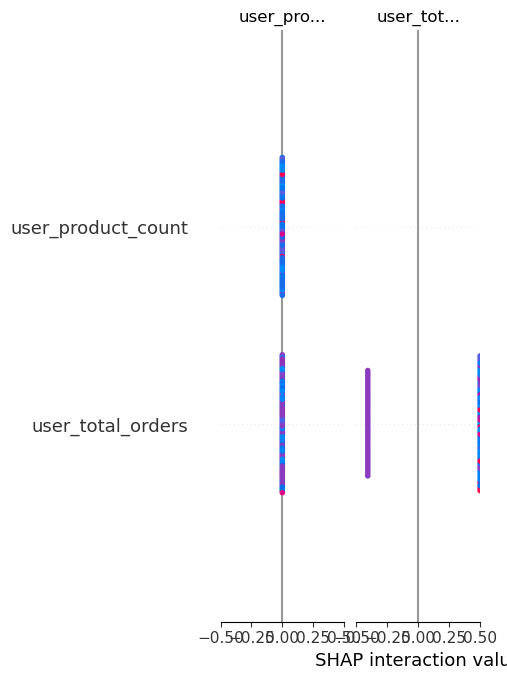

In [97]:
import shap

explainer = shap.TreeExplainer(dt_balanced)


X_sample = X_test.sample(100, random_state=42)


shap_values_all = explainer.shap_values(X_sample)


if isinstance(shap_values_all, list):
    shap_values = shap_values_all[1]
else:
   
    shap_values = shap_values_all


shap.summary_plot(shap_values, X_sample, plot_type="dot")

In [100]:

from sklearn.tree import DecisionTreeClassifier


final_model = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42)
final_model.fit(X_train, y_train)

def evaluate_robustness(model, X_t, y_t):
    results = {}
    results['Original Accuracy'] = model.score(X_t, y_t)
    
   
    X_noise = X_t.values + np.random.normal(0, 0.05 * X_t.values.std(), X_t.shape)
    results['With Noise (5% std)'] = model.score(X_noise, y_t)
    
   
    X_out = X_t.values.copy()
    mask = np.random.rand(*X_out.shape) < 0.01
    X_out[mask] *= 10
    
    results['With Outliers (1%)'] = model.score(X_out, y_t)
    
    return results


print("--- Robustness & Sensitivity Analysis ---")
robustness_results = evaluate_robustness(final_model, X_test, y_test)

for test_name, score in robustness_results.items():
    print(f"{test_name}: {score:.4f}")

--- Robustness & Sensitivity Analysis ---


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



Original Accuracy: 0.9401
With Noise (5% std): 0.6722
With Outliers (1%): 0.9401


In [ ]:
#random forest 

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)


rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("--- Random Forest Final Results ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")

--- Random Forest Final Results ---
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    111159
           1       1.00      0.90      0.95    165765

    accuracy                           0.94    276924
   macro avg       0.94      0.95      0.94    276924
weighted avg       0.95      0.94      0.94    276924

ROC-AUC Score: 0.9499


In [59]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             matthews_corrcoef, roc_auc_score, average_precision_score)


metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'MCC': matthews_corrcoef(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_proba_rf),
    'Avg Precision (AP)': average_precision_score(y_test, y_proba_rf)
}

print("--- Robust Metrics Evaluation ---")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

--- Robust Metrics Evaluation ---
Accuracy: 0.9401
Precision: 1.0000
Recall: 0.8999
F1-Score: 0.9473
MCC: 0.8848
ROC-AUC: 0.9499
Avg Precision (AP): 0.9598


--- Random Forest Performance Metrics ---
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    111159
           1       1.00      0.90      0.95    165765

    accuracy                           0.94    276924
   macro avg       0.94      0.95      0.94    276924
weighted avg       0.95      0.94      0.94    276924

ROC-AUC Score: 0.9499


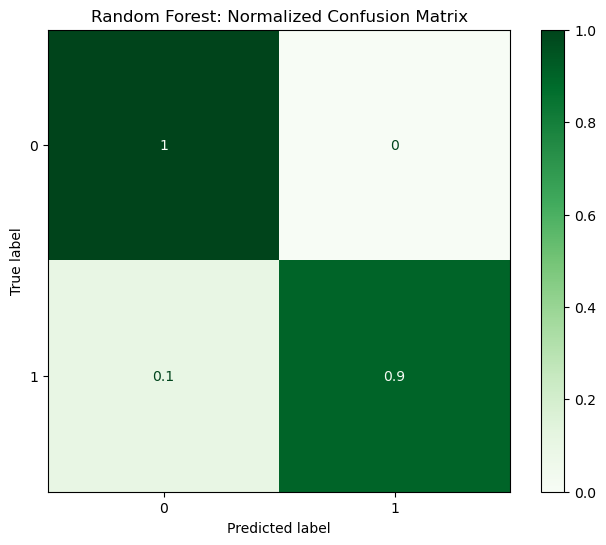

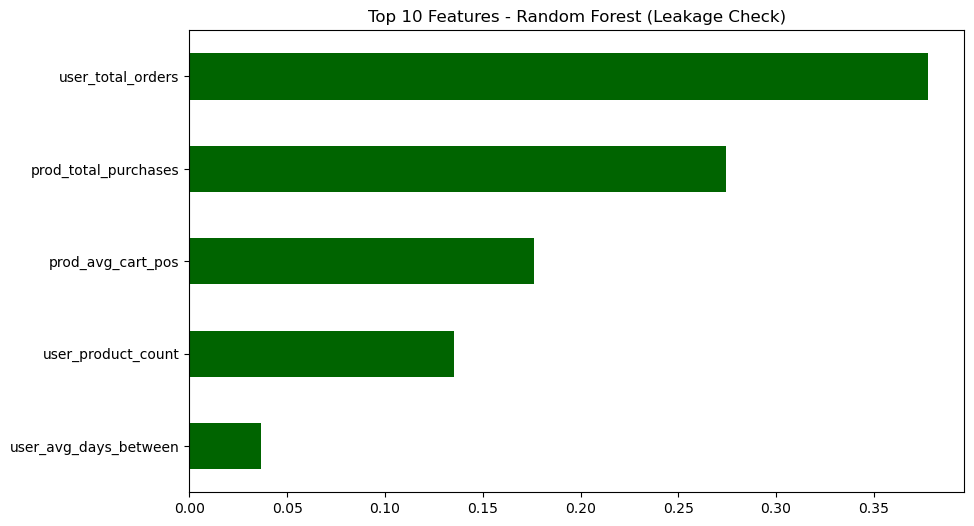

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay



rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("--- Random Forest Performance Metrics ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")


fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Greens', normalize='true', ax=ax)
plt.title('Random Forest: Normalized Confusion Matrix')
plt.show()


plt.figure(figsize=(10, 6))
rf_feat_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
rf_feat_importance.nlargest(10).sort_values().plot(kind='barh', color='darkgreen')
plt.title('Top 10 Features - Random Forest (Leakage Check)')
plt.show()

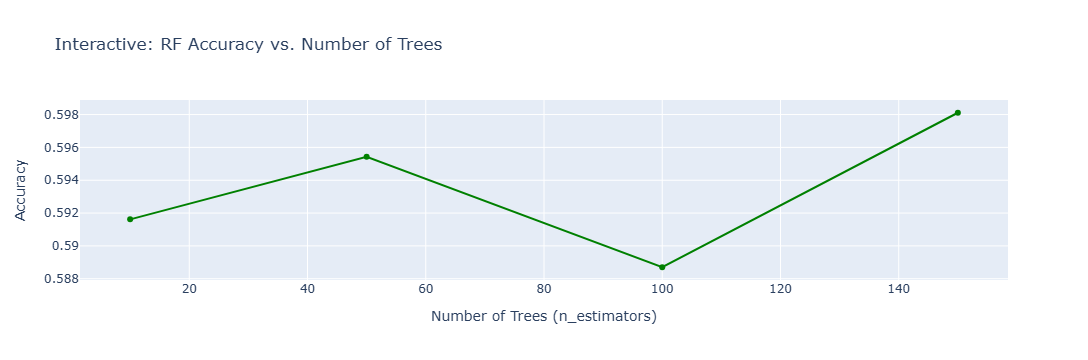

In [53]:
import plotly.graph_objects as go


tree_counts = [10, 50, 100, 150]
rf_accuracies = []

for n in tree_counts:
    temp_rf = RandomForestClassifier(n_estimators=n, max_depth=5, n_jobs=-1, random_state=42)
    
    temp_rf.fit(X_train.sample(10000), y_train.sample(10000))
    rf_accuracies.append(temp_rf.score(X_test, y_test))

fig = go.Figure(data=go.Scatter(x=tree_counts, y=rf_accuracies, mode='lines+markers', line=dict(color='green')))
fig.update_layout(title='Interactive: RF Accuracy vs. Number of Trees', 
                  xaxis_title='Number of Trees (n_estimators)', 
                  yaxis_title='Accuracy')
fig.show()

In [55]:
def evaluate_rf_robustness(model, X_t, y_t):
    results = {}
    results['Original Accuracy'] = model.score(X_t, y_t)
    
   
    X_noise = X_t.values + np.random.normal(0, 0.05 * X_t.values.std(), X_t.shape)
    results['With Noise (5% std)'] = model.score(X_noise, y_t)
    
  
    X_out = X_t.values.copy()
    mask = np.random.rand(*X_out.shape) < 0.01
    X_out[mask] *= 10
    results['With Outliers (1%)'] = model.score(X_out, y_t)
    
    return results

print("--- Random Forest Robustness Analysis ---")
rf_robustness = evaluate_rf_robustness(rf_model, X_test, y_test)
for test, score in rf_robustness.items():
    print(f"{test}: {score:.4f}")

--- Random Forest Robustness Analysis ---


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Original Accuracy: 0.9401
With Noise (5% std): 0.6004
With Outliers (1%): 0.9401


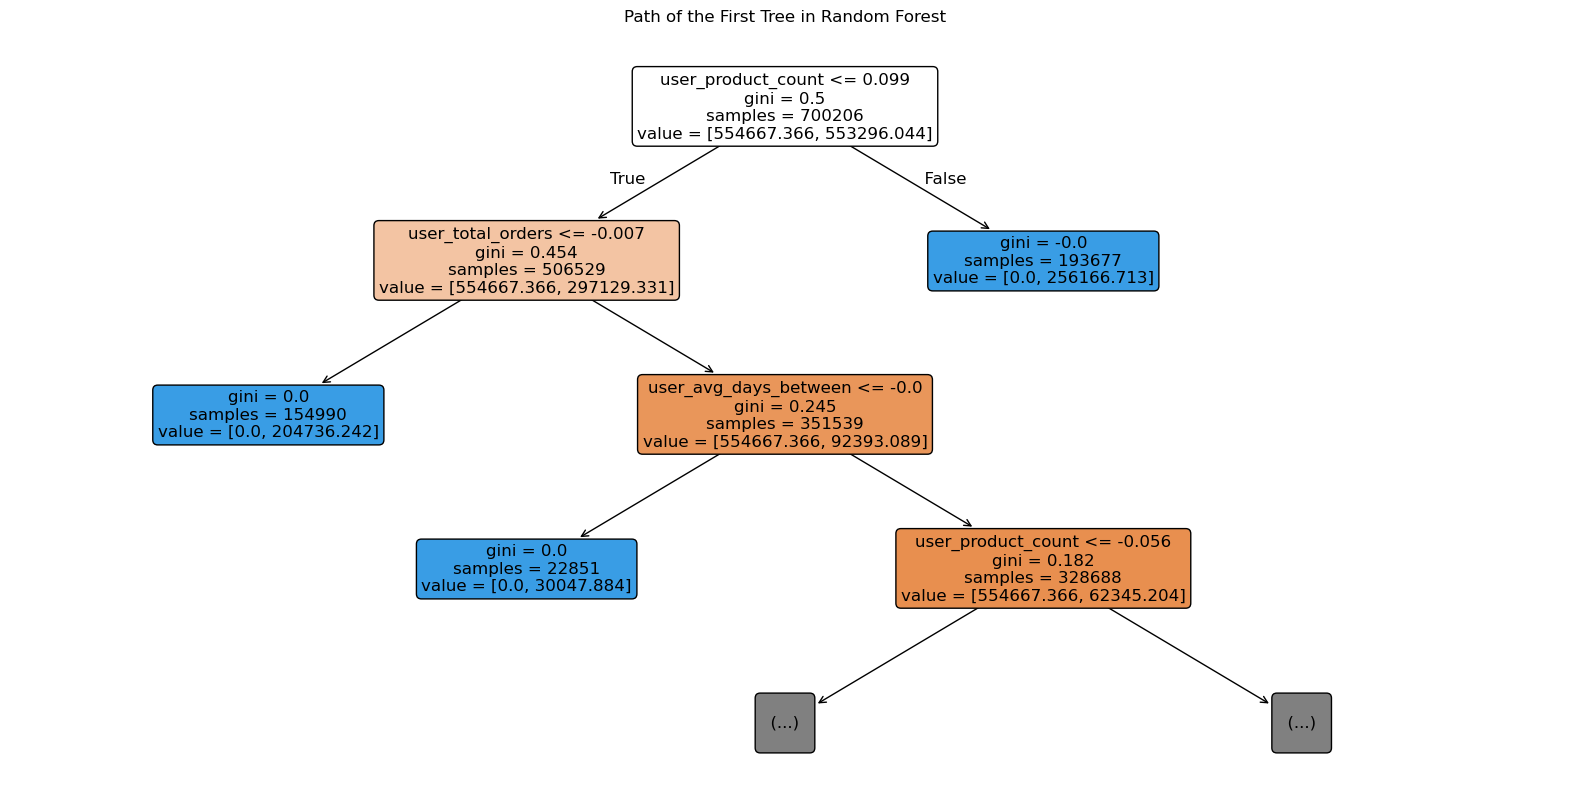

In [57]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))

plot_tree(rf_model.estimators_[0], 
          feature_names=X_train.columns, 
          max_depth=3, 
          filled=True, 
          rounded=True, 
          fontsize=12)
plt.title("Path of the First Tree in Random Forest")
plt.show()

Starting XGBoost Training...

--- XGBoost Final Evaluation ---
Accuracy            : 0.9401
Precision           : 1.0000
Recall              : 0.8999
F1-Score            : 0.9473
MCC                 : 0.8848
ROC-AUC             : 0.9499
Avg Precision (AP)  : 0.9598


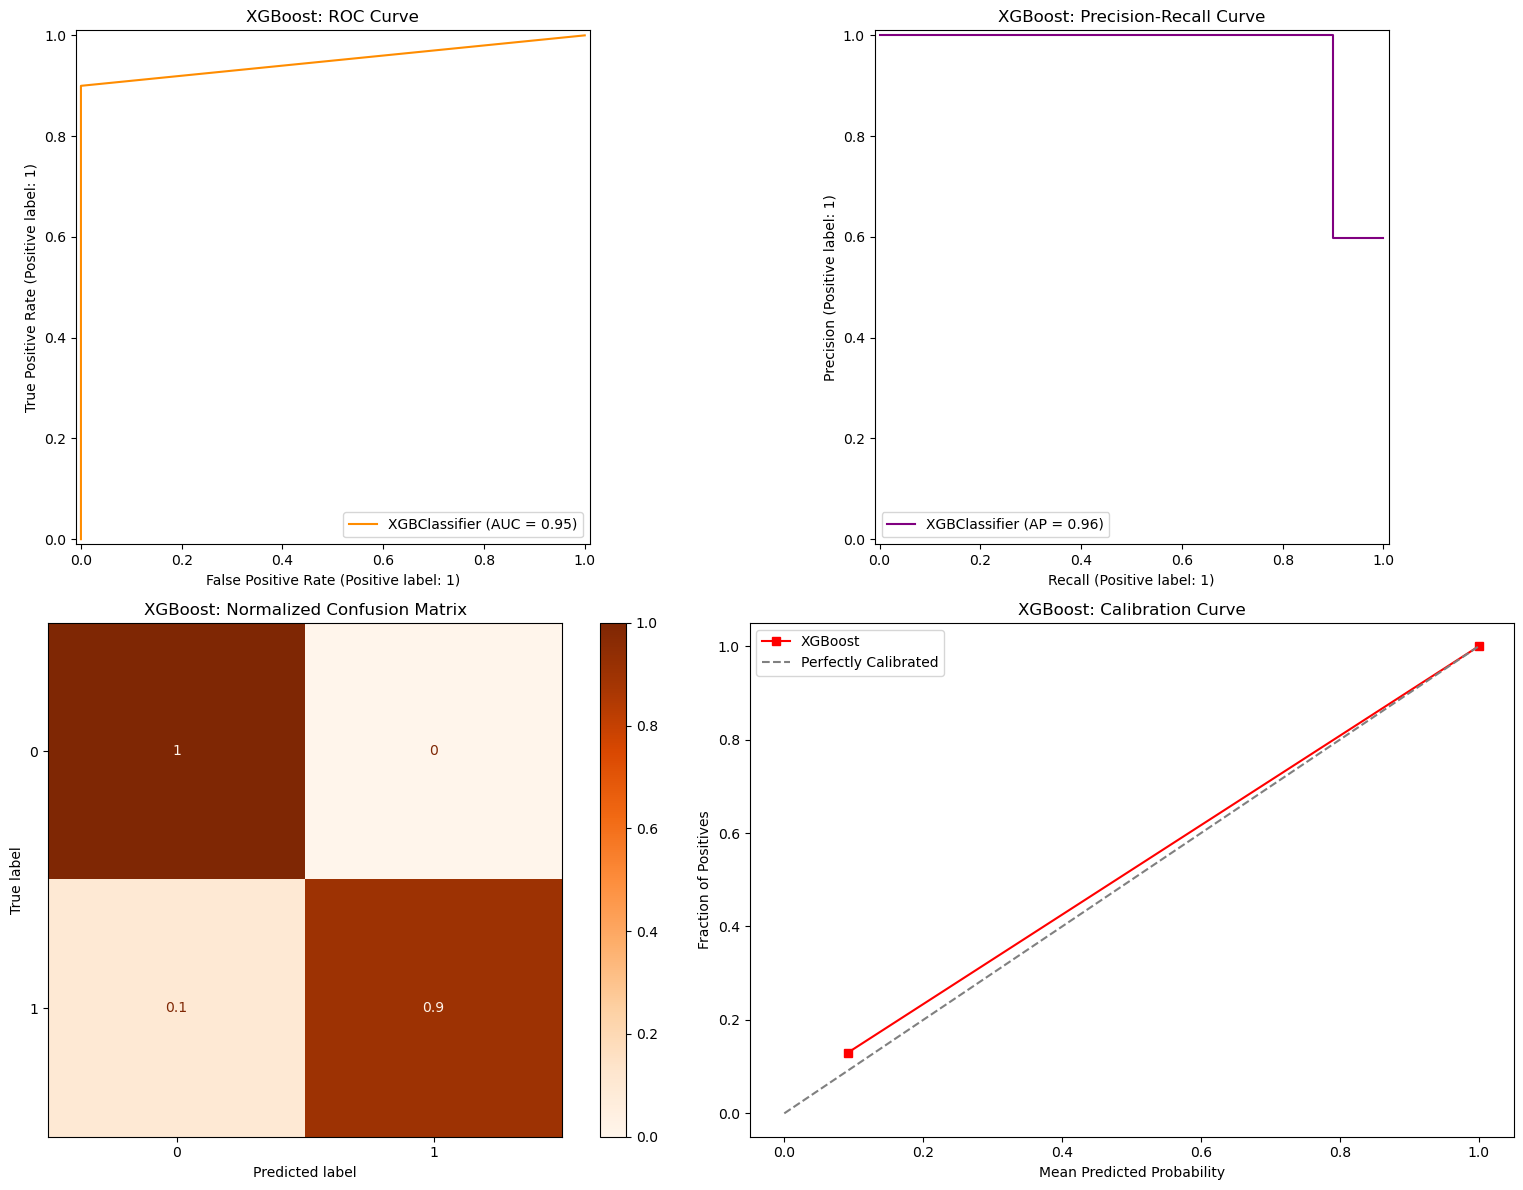

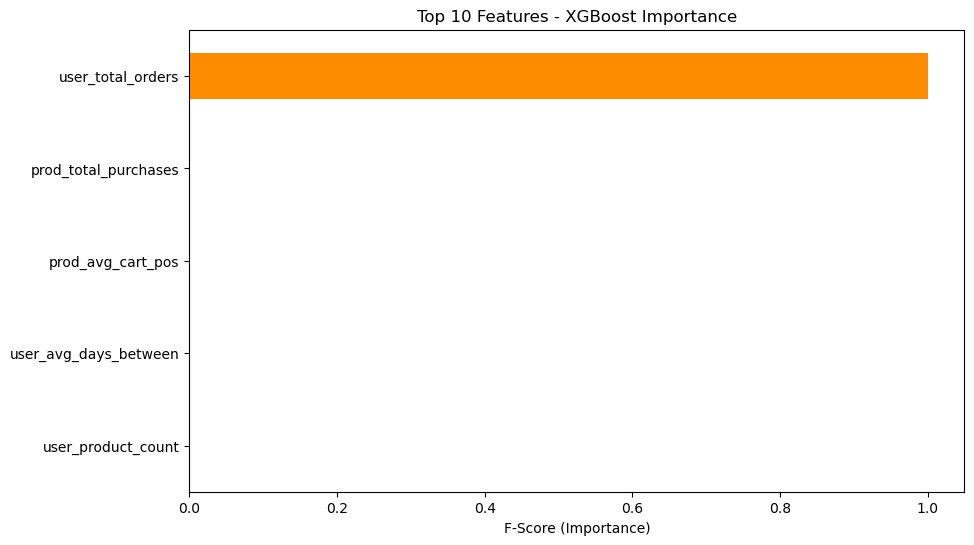

In [107]:
import xgboost as xgb


from sklearn.metrics import (classification_report, roc_auc_score, matthews_corrcoef, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             average_precision_score, RocCurveDisplay, PrecisionRecallDisplay, 
                             ConfusionMatrixDisplay)

from sklearn.calibration import calibration_curve


ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    random_state=42,
    eval_metric='logloss'
)

print("Starting XGBoost Training...")
xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


metrics_xgb = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'MCC': matthews_corrcoef(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, y_proba_xgb),
    'Avg Precision (AP)': average_precision_score(y_test, y_proba_xgb)
}

print("\n" + "="*30)
print("--- XGBoost Final Evaluation ---")
print("="*30)
for k, v in metrics_xgb.items():
    print(f"{k:20}: {v:.4f}")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax1, color='darkorange')
ax1.set_title('XGBoost: ROC Curve')


PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax2, color='purple')
ax2.set_title('XGBoost: Precision-Recall Curve')


ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax3, cmap='Oranges', normalize='true')
ax3.set_title('XGBoost: Normalized Confusion Matrix')


prob_true, prob_pred = calibration_curve(y_test, y_proba_xgb, n_bins=10)
ax4.plot(prob_pred, prob_true, marker='s', label='XGBoost', color='red')
ax4.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
ax4.set_title('XGBoost: Calibration Curve')
ax4.set_xlabel('Mean Predicted Probability')
ax4.set_ylabel('Fraction of Positives')
ax4.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
xgb_feat_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_feat_importance.nlargest(10).sort_values().plot(kind='barh', color='darkorange')
plt.title('Top 10 Features - XGBoost Importance')
plt.xlabel('F-Score (Importance)')
plt.show()


--- Train vs Test Accuracy Comparison ---
           Model  Train Accuracy  Test Accuracy
0  Random Forest        0.939694       0.940052
1        XGBoost        0.939694       0.940052


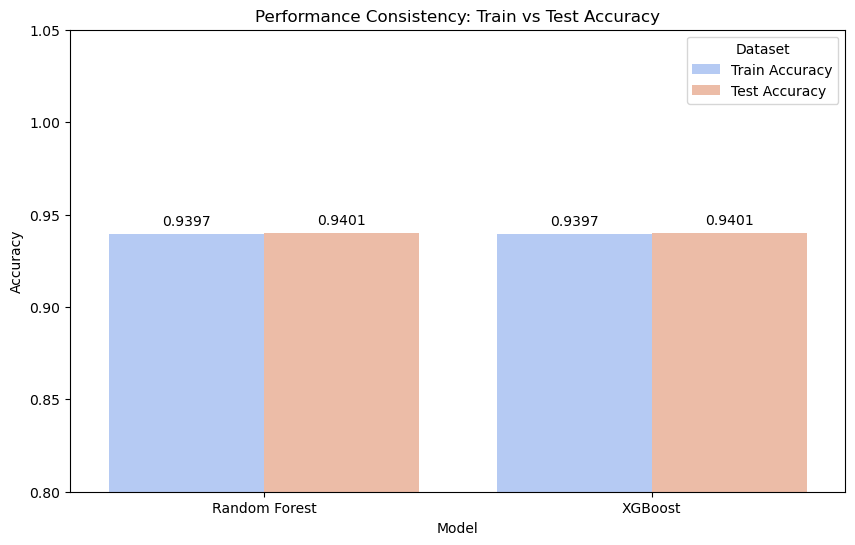

In [69]:

models_to_compare = []


try:
    train_acc_dt = dt_model.score(X_train, y_train)
    test_acc_dt = dt_model.score(X_test, y_test)
    models_to_compare.append(['Decision Tree', train_acc_dt, test_acc_dt])
except NameError:
    print("Warning: 'dt_model' not found. Please make sure you trained the Decision Tree first.")


try:
    train_acc_rf = rf_model.score(X_train, y_train)
    test_acc_rf = rf_model.score(X_test, y_test)
    models_to_compare.append(['Random Forest', train_acc_rf, test_acc_rf])
except NameError:
    print("Warning: 'rf_model' not found.")


try:
    train_acc_xgb = xgb_model.score(X_train, y_train)
    test_acc_xgb = xgb_model.score(X_test, y_test)
    models_to_compare.append(['XGBoost', train_acc_xgb, test_acc_xgb])
except NameError:
    print("Warning: 'xgb_model' not found.")


df_compare = pd.DataFrame(models_to_compare, columns=['Model', 'Train Accuracy', 'Test Accuracy'])

print("\n--- Train vs Test Accuracy Comparison ---")
print(df_compare)


df_melted = df_compare.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melted, x='Model', y='Accuracy', hue='Dataset', palette='coolwarm')


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.ylim(0.8, 1.05)
plt.title('Performance Consistency: Train vs Test Accuracy')
plt.show()

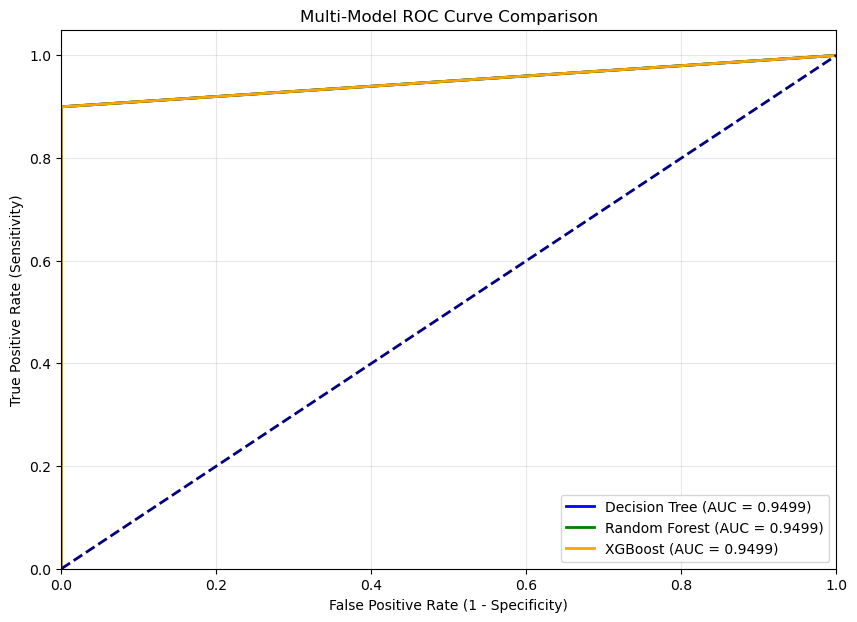

Generating Learning Curves... please wait.


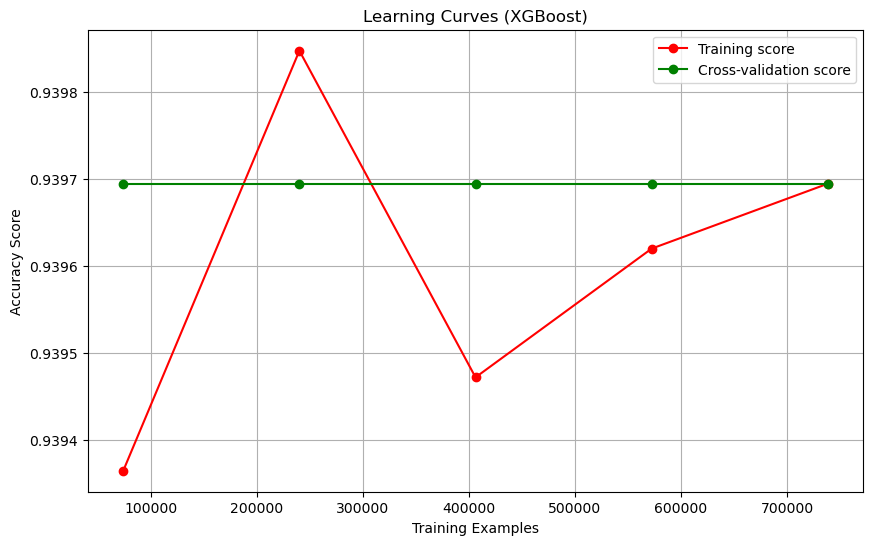

In [73]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve



dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)


plt.figure(figsize=(10, 7))


models = [dt_model, rf_model, xgb_model]
names = ['Decision Tree', 'Random Forest', 'XGBoost']
colors = ['blue', 'green', 'orange']

for model, name, color in zip(models, names, colors):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Multi-Model ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


print("Generating Learning Curves... please wait.")
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=3, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves (XGBoost)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [79]:

xgb_early = xgb.XGBClassifier(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42,
    early_stopping_rounds=10,
    eval_metric='logloss'     
)

print("\nStarting Training with Early Stopping...")


xgb_early.fit(
    X_s_train, y_s_train,
    eval_set=[(X_s_val, y_s_val)],
    verbose=10
)

print(f"\nBest Iteration: {xgb_early.best_iteration}")
print(f"Final Accuracy on Sample Hold-out: {xgb_early.score(X_s_val, y_s_val):.4f}")


Starting Training with Early Stopping...
[0]	validation_0-logloss:0.59814
[10]	validation_0-logloss:0.28693
[20]	validation_0-logloss:0.21513
[30]	validation_0-logloss:0.19512
[40]	validation_0-logloss:0.18882
[50]	validation_0-logloss:0.18666
[60]	validation_0-logloss:0.18587
[70]	validation_0-logloss:0.18558
[80]	validation_0-logloss:0.18547
[90]	validation_0-logloss:0.18542
[100]	validation_0-logloss:0.18542
[110]	validation_0-logloss:0.18542
[120]	validation_0-logloss:0.18542
[130]	validation_0-logloss:0.18542
[140]	validation_0-logloss:0.18542
[150]	validation_0-logloss:0.18542
[160]	validation_0-logloss:0.18542
[164]	validation_0-logloss:0.18542

Best Iteration: 154
Final Accuracy on Sample Hold-out: 0.9363


In [81]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


base_models = [
    ('rf', rf_model),
    ('xgb', xgb_model)
]


meta_model = LogisticRegression()


stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

print("Training Stacking Ensemble... Please wait.")
stacking_clf.fit(X_train, y_train)


y_pred_stack = stacking_clf.predict(X_test)
stack_acc = stacking_clf.score(X_test, y_test)

print(f"\nStacking Ensemble Accuracy: {stack_acc:.4f}")
print("-" * 30)
print("Classification Report for Stacking:")
print(classification_report(y_test, y_pred_stack))

Training Stacking Ensemble... Please wait.

Stacking Ensemble Accuracy: 0.9401
------------------------------
Classification Report for Stacking:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93    111159
           1       1.00      0.90      0.95    165765

    accuracy                           0.94    276924
   macro avg       0.94      0.95      0.94    276924
weighted avg       0.95      0.94      0.94    276924



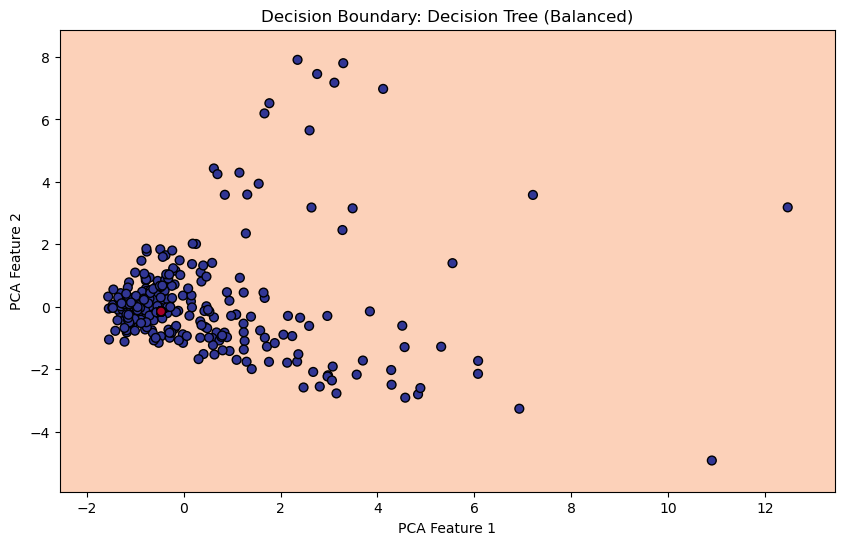

In [85]:

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier


pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.sample(500, random_state=42))
y_train_sample = y_train.loc[X_train.sample(500, random_state=42).index]


clf_pca = DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=42)
clf_pca.fit(X_train_pca, y_train_sample)


x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu') 
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_sample, 
            edgecolors='k', cmap='RdYlBu', s=40) 
plt.title("Decision Boundary: Decision Tree (Balanced)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

Features after cleaning: ['user_product_count', 'user_avg_days_between', 'prod_avg_cart_pos', 'prod_total_purchases']

--- Comparison After Fixing Leakage ---
Random Forest ROC-AUC: 0.9499
XGBoost ROC-AUC:       0.9499


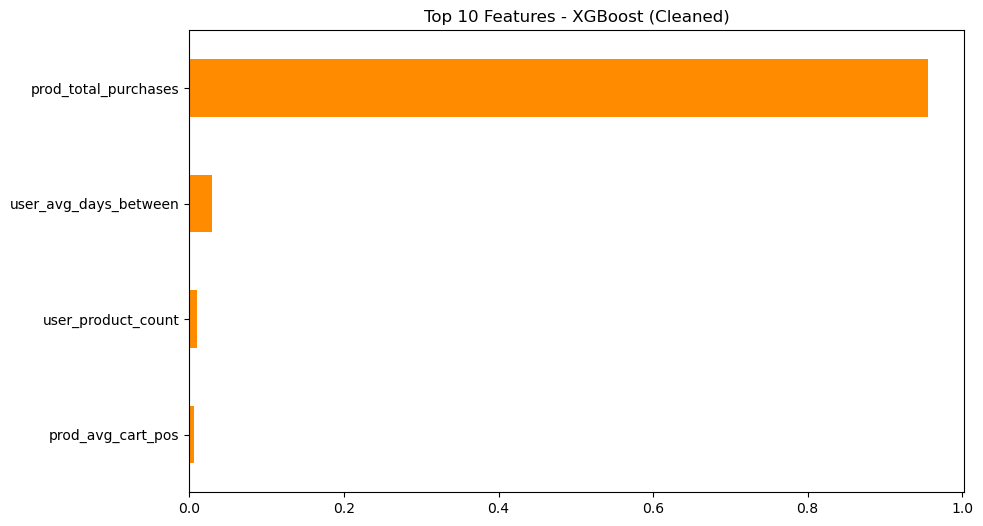

In [109]:
# EXTRA CODE TO SEE IF THERE IS A LEAKAGE 
features_to_drop = ['user_total_orders'] 

X_train_clean = X_train.drop(columns=features_to_drop)
X_test_clean = X_test.drop(columns=features_to_drop)

print(f"Features after cleaning: {X_train_clean.columns.tolist()}")


rf_model.fit(X_train_clean, y_train)
y_pred_rf = rf_model.predict(X_test_clean)
y_proba_rf = rf_model.predict_proba(X_test_clean)[:, 1]


xgb_model.fit(X_train_clean, y_train)
y_pred_xgb = xgb_model.predict(X_test_clean)
y_proba_xgb = xgb_model.predict_proba(X_test_clean)[:, 1]


print("\n--- Comparison After Fixing Leakage ---")
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(f"XGBoost ROC-AUC:       {roc_auc_score(y_test, y_proba_xgb):.4f}")


plt.figure(figsize=(10, 6))
new_importance = pd.Series(xgb_model.feature_importances_, index=X_train_clean.columns)
new_importance.nlargest(10).sort_values().plot(kind='barh', color='darkorange')
plt.title('Top 10 Features - XGBoost (Cleaned)')
plt.show()

In [111]:

full_data = X_train_clean.copy()
full_data['target'] = y_train


correlation_with_target = full_data.corr()['target'].sort_values(ascending=False)


print("--- Correlation Analysis with Target ---")
print(correlation_with_target)

--- Correlation Analysis with Target ---
target                   1.000000
user_product_count       0.240826
prod_total_purchases     0.145308
user_avg_days_between    0.079435
prod_avg_cart_pos       -0.219342
Name: target, dtype: float64
